In [1]:
import numpy as np
import time
import datetime
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from config.cli import get_parameters

from utils import plot_results_2d, setup_optimizer_and_scheduler, save_checkpoint, load_checkpoint, DATASET_INFO
from utils import L63, L96, rk4, AverageMeter, mystery_operator, partial_obs_operator, get_dataloader, batch_covariance
from EnKF_utils import StochasticENKF_analysis, loc_EnKF_analysis, EnKF_analysis, post_process, mrdiv, mean0
from networks import ComplexAttentionModel, AttentionModel, NaiveNetwork, SetTransformer, Simple_MLP
from localization import pairwise_distances, dist2coeff, create_loc_mat

In [4]:
dataset = 'lorenz96'

ori_dim = DATASET_INFO[dataset]['dim']
obs_dim = DATASET_INFO[dataset]['obs_dim']
obs_inds = DATASET_INFO[dataset]['obs_inds']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
st_output_dim = 64

full_inds = torch.arange(0, ori_dim)
Lvy = pairwise_distances(full_inds[:, None], obs_inds[:, None], domain=(ori_dim,)).to(device)
Lyy = pairwise_distances(obs_inds[:, None], obs_inds[:, None], domain=(ori_dim,)).to(device)
diff_dist = torch.unique(torch.cat((Lvy.flatten(), Lyy.flatten())))
num_dist = len(diff_dist)
Lvy = Lvy
Lyy = Lyy

input_dim = ori_dim + 2 * obs_dim + st_output_dim * 2 # D + d + d + 64*2
local_input_dim = obs_dim + st_output_dim * 2 # d + 64*2

In [ ]:
def compute_relative_error(model_initial, model_finetuned):
    total_diff = 0.0
    initial_norm = 0.0
    for param_init, param_ft in zip(model_initial.parameters(), model_finetuned.parameters()):
        total_diff += torch.norm(param_init - param_ft).item()  
        initial_norm += torch.norm(param_init).item()  
    relative_error = total_diff / initial_norm if initial_norm > 0 else 0
    return relative_error

Checkpoint loaded from save/2024-11-06_13-43lorenz96_0.7_10_60_8192_EnST_normalized_l2/cp_1000.pth
Checkpoint loaded from save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_10.pth
Checkpoint loaded from save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_20.pth
Checkpoint loaded from save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_30.pth
Checkpoint loaded from save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_40.pth
Checkpoint loaded from save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_50.pth


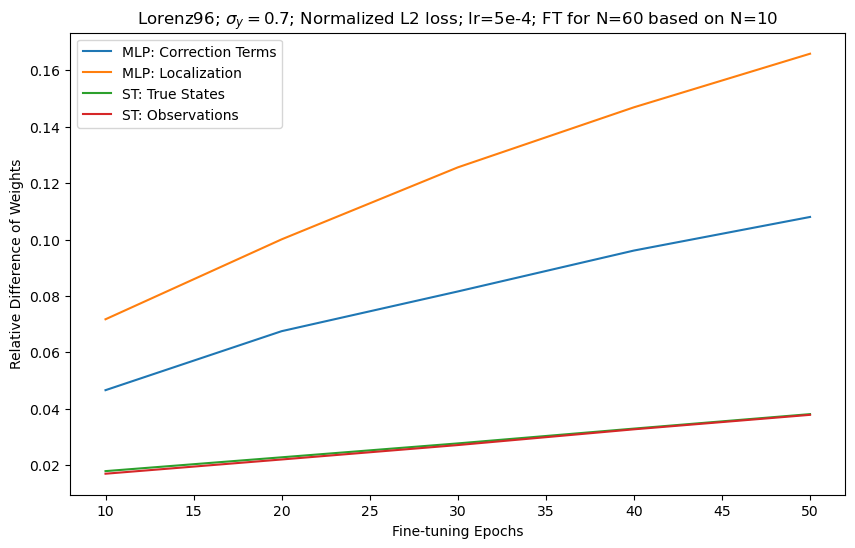

In [14]:
model_list_initial = [Simple_MLP(d_input=input_dim, d_output=obs_dim + 2 * ori_dim, num_hidden_layers=2).to(device),
                      Simple_MLP(d_input=local_input_dim, d_output=num_dist, num_hidden_layers=2).to(device),
                      SetTransformer(input_dim=ori_dim, num_heads=8, num_inds=16, output_dim=st_output_dim, hidden_dim=32, num_layers=1).to(device),
                      SetTransformer(input_dim=obs_dim, num_heads=8, num_inds=16, output_dim=st_output_dim, hidden_dim=32, num_layers=1).to(device)]

load_checkpoint(model_list_initial, None, None, filename='save/2024-11-06_13-43lorenz96_0.7_10_60_8192_EnST_normalized_l2/cp_1000.pth')  # weights before fine-tuning

relative_errors = {i: [] for i in range(4)}
ft_epochs = [10,20,30,40,50]
name_list = ['MLP: Correction Terms', 'MLP: Localization', 'ST: True States', 'ST: Observations']

checkpoints = [f'save/2024-11-07_15-29lorenz96_0.7_20_50_4096_EnST_tuned_normalized_l2/ft_cp_60_{n}.pth' for n in ft_epochs]

for cp in checkpoints:
    model_list_finetuned = [Simple_MLP(d_input=input_dim, d_output=obs_dim + 2 * ori_dim, num_hidden_layers=2).to(device),
                            Simple_MLP(d_input=local_input_dim, d_output=num_dist, num_hidden_layers=2).to(device),
                            SetTransformer(input_dim=ori_dim, num_heads=8, num_inds=16, output_dim=st_output_dim, hidden_dim=32, num_layers=1).to(device),
                            SetTransformer(input_dim=obs_dim, num_heads=8, num_inds=16, output_dim=st_output_dim, hidden_dim=32, num_layers=1).to(device)]
    
    load_checkpoint(model_list_finetuned, None, None, filename=cp)  # weights after fine-tuning
    
    for i, (initial_model, finetuned_model) in enumerate(zip(model_list_initial, model_list_finetuned)):
        relative_error = compute_relative_error(initial_model, finetuned_model)
        relative_errors[i].append(relative_error)

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(ft_epochs, relative_errors[i], label=name_list[i])

plt.xlabel('Fine-tuning Epochs')
plt.ylabel('Relative Difference of Weights')
plt.title(r'Lorenz96; $\sigma_y=0.7$; Normalized L2 loss; lr=5e-4; FT for N=60 based on N=10')
plt.legend()
# plt.grid(True)
plt.savefig(os.path.join('save/figures', f"FT_10_60.png"), bbox_inches="tight", dpi=200)
plt.show()